The original version of this notebook can be find at [this repository.](https://github.com/JWST-Templates/Notebooks/blob/main/MIRI_MRS_reduction_SPT0418-47_PAH_ch3long.ipynb)

# SPT0418-47 MIRI MRS Reduction Notebook

By the TEMPLATES ERS team, last updated 2023 June 1

J. Spilker, K. A. Phadke, D. Law

Mostly cobbled together from STScI and D. Law notebooks with additional custom processing steps.

This notebook demonstrates how to reduce IFU data from the MIRI MRS instrument beginning from the raw exposure files through to a fully science-ready data cube. In particular we show how the TEMPLATES team is currently addressing the so-called 'cosmic ray shower' artifacts that limit the achievable depth of MRS observations. We expect (and hope!) that the pipeline will eventually be mature enough to deal with these artifacts, but as of early 2023 the method we demonstrate here worked better for our use case.

This notebook was primarily developed to support the analysis in [Spilker et al. (2023)](https://www.nature.com/articles/s41586-023-05998-6). If you find this notebook useful, please cite the paper! If you have suggestions for better data processing, please contact us! We're interested in getting current best practices distributed widely throughout the community.

Requirements: 
- Common scientific python packages: numpy, matplotlib, astropy
- Working installed version of the JWST pipeline
- The [miricoord](https://github.com/STScI-MIRI/miricoord/) package for MRS coordinate transforms
- The [photutils](https://photutils.readthedocs.io/en/stable/) package for cosmic ray shower artifact removal

This notebook is organized into a few different stages:
1. [Data and Processing Overview](#Data-and-Processing-Overview)
2. [Imports and Prep](#Imports-and-Prep)
3. [Stage 1 Detector Pipeline Processing](#Stage-1-Detector-Pipeline-Processing)
4. [Refine Bad Pixel Mask](#Refine-Bad-Pixel-Mask)
5. [Stage 2 Pipeline Processing](#Stage-2-Pipeline-Processing)
6. [Stage 3 Pipeline Processing](#Stage-3-Pipeline-Processing)
7. [Post-pipeline Cube Stripe Removal](#Post-pipeline-Cube-Stripe-Removal)
8. [Cube Analysis and Spectral Extraction](#Cube-Analysis-and-Spectral-Extraction)
9. [Lessons Learned and Future Improvements](#Lessons-Learned-and-Future-Improvements)

## Data and Processing Overview

In this notebook we will demonstrate the reduction of MIRI MRS data acquired as part of the TEMPLATES ERS program (#1355). ~~The target galaxy is SPT0418-47, an IR-selected dusty galaxy at z=4.22 gravitationally lensed by a foreground galaxy at z=0.26.~~ The goal of the observations was to detect and spatially resolve emission from the 3.3um polycyclic aromatic hydrocarbon (PAH) feature. This feature is normally faint and is intrinsically broad, with FWHM~3000km/s, much larger than the line width of the gas-phase emission lines in the galaxy. This makes the data analysis challenging, because the emission we care about is extended both spatially and spectrally, and is quite faint.

The data were taken on 8 August 2022. The PAH feature is redshifted into Channel 3 of the LONG ('C') grating, so the data cover the 4 separate wavelength ranges of the LONG grating (see the [MRS documentation](https://jwst-docs.stsci.edu/jwst-mid-infrared-instrument/miri-observing-modes/miri-medium-resolution-spectroscopy#MIRIMediumResolutionSpectroscopy-wavelengthMRSwavelengthcoverage) for details). In Channel 3 the MRS field of view is about 5.2" x 6.1" with a spectral resolving power R~2600. We used the SLOWR1 detector readout pattern (note that current best practice is to use FAST readout). We observed with a standard 4-point dither pattern for a total on-source exposure time of 3440s. The science observations were accompanied by dedicated background exposures with the same 4-point dither pattern and exposure time. There were also simultaneous exposures taken with the MIRI imager during the on-source MRS exposures, but we ignore those here.

## Imports and Prep

We start by importing required packages and organizing our directory structure. You will need to download the raw (level 0) IFU exposures from MAST and place them in the `uncal_files` folder.

Here is a direct link to the MRS exposures: [SPT0418-47 MIRI/MRS LONG](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html?searchQuery=%7B%22service%22%3A%22CAOMFILTERED%22%2C%22inputText%22%3A%5B%7B%22paramName%22%3A%22obs_collection%22%2C%22niceName%22%3A%22obs_collection%22%2C%22values%22%3A%5B%22JWST%22%5D%2C%22valString%22%3A%22JWST%22%2C%22isDate%22%3Afalse%2C%22separator%22%3A%22%3B%22%2C%22facetType%22%3A%22discrete%22%2C%22displayString%22%3A%22JWST%22%7D%2C%7B%22paramName%22%3A%22instrument_name%22%2C%22niceName%22%3A%22instrument_name%22%2C%22values%22%3A%5B%22MIRI%22%5D%2C%22valString%22%3A%22MIRI%22%2C%22isDate%22%3Afalse%2C%22facetType%22%3A%22discrete%22%2C%22displayString%22%3A%22MIRI%22%7D%2C%7B%22paramName%22%3A%22filters%22%2C%22niceName%22%3A%22filters%22%2C%22values%22%3A%5B%22MRS%22%5D%2C%22valString%22%3A%22MRS%22%2C%22isDate%22%3Afalse%2C%22separator%22%3A%22%3B%22%2C%22facetType%22%3A%22discrete%22%2C%22displayString%22%3A%22MRS%22%7D%2C%7B%22paramName%22%3A%22proposal_id%22%2C%22niceName%22%3A%22proposal_id%22%2C%22values%22%3A%5B%5D%2C%22valString%22%3A%221355%22%2C%22isDate%22%3Afalse%2C%22freeText%22%3A%221355%22%2C%22displayString%22%3A%221355%22%7D%2C%7B%22paramName%22%3A%22t_min%22%2C%22niceName%22%3A%22t_min%22%2C%22values%22%3A%5B%7B%22min%22%3A59792.041666667%2C%22max%22%3A59822.041666667%7D%5D%2C%22valString%22%3A%22%5B59792.041666667%2C%2059822.041666667%5D%22%2C%22isDate%22%3Afalse%2C%22facetType%22%3A%22numeric%22%2C%22min%22%3A59792.041666667%2C%22max%22%3A59822.041666667%2C%22displayString%22%3A%22%5B59792.041666667%2C%2059822.041666667%5D%22%7D%5D%2C%22position%22%3A%22undefined%2C%20undefined%2C%20undefined%22%2C%22paramsService%22%3A%22Mast.Caom.Filtered%22%2C%22title%22%3A%22MAST%3A%20%20Advanced%20Search%202%22%2C%22tooltip%22%3A%22JWST%3B%20MIRI%3B%20MRS%3B%201355%3B%20%5B59792.041666667%2C%2059822.041666667%5D%3B%20%22%2C%22columns%22%3A%22*%22%2C%22columnsConfig%22%3A%22Mast.Caom.Cone%22%7D)

To download the data products, click the checkbox on the left-hand side of the search results list to select all rows, and then click the 'Add to download basket' button along the top-right of the results window. Because we want to start with the raw uncalibrated data, in the download manager popup window that appears, *uncheck* the box for 'Minimum Recommended Products'. That will allow you to download data products at any other stage of processing. Scroll down to the 'Group' filter and check the box for UNCAL exposures - there should be 16: two MIRI detector exposures at 4 dither positions for each of the on- and off-source exposures. Download all 16 of these files and place the .fits files into a folder named `uncal_files`.

Explanation of uncal file naming, example `jw01355017001_02101_00001_mirifulong_uncal.fits`:
- `jw`    = JWST
- `01355` = TEMPLATES program ID number
- `017`   = Observation number
- `001`   = Visit number
- `02101` = The `02` exposures are on-source, the `04` exposures are backgrounds.
- `00001` = Exposure number, 1 to 4 for each dither position at both on- and off-source
- `mirifulong` = Long- (or short-) wavelength MRS detector. Note this is not the same as the SHORT/MEDIUM/LONG grating specifications (it's confusing!). Channels 1 and 2 are always on the short detector, 3 and 4 always on the long detector, regardless of the grating setting.
- `uncal` = We are starting on the raw uncalibrated exposures
- `fits`  = This file is in the "Flexible Image Transport System" format, perhaps you've heard of it?

In [1]:
# If you want plots to render in this notebook:
# %matplotlib inline
from IPython.display import Image

# Standard imports
import os, sys, glob, yaml
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits


# This is here to connect to the CRDS server and download the necessary calibration files.
os.environ["CRDS_SERVER_URL"] = "https://jwst-crds.stsci.edu"
os.environ["CRDS_PATH"] = "/home/fatih/crds_cache"
os.environ.pop("CRDS_SERVERLESS_MODE", None)

# JWST-specific imports
import jwst
import stcal

# We will make our own JWST pipeline objects, so import those separately
from jwst.pipeline import Detector1Pipeline, Spec2Pipeline, Spec3Pipeline

# Additional pipeline utilities
from jwst import datamodels                                         # work with 'data models'
from jwst.datamodels import dqflags                                 # Work with data quality (DQ) arrays
from jwst.associations import asn_from_list as afl                  # Helper for pipeline association files
from jwst.associations.lib.rules_level2_base import DMSLevel2bBase  # Create a new custom Lvl2 association file
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base # Create a new custom Lvl3 association file


import importlib

# Utilities for MIRI coordinate transforms and mappings, see:
# https://github.com/STScI-MIRI/miricoord/

local_miricoord = '/home/fatih/G165_main/miricoord'

if os.path.exists(local_miricoord):
    sys.path.insert(0, local_miricoord)

import miricoord
import miricoord.mrs.mrs_tools as mrstools
# importlib.reload(miricoord.mrs.mrs_tools)


# These are used to estimate and remove the residual CR shower striping
# from the pipe-processed cubes.

from photutils.aperture import CircularAperture, CircularAnnulus, SkyCircularAperture, SkyCircularAnnulus, aperture_photometry
from photutils.background import Background2D, MedianBackground

"""
The following two lines gave an error 'ImportError: cannot import name 'CircularAperture' from 'photutils'...'. 
The upper two lines worked. ChatGPT said "If that works, it means photutils does not export these at the top-level 
__init__.py but only from the submodules." Long story short, these modules are under the aperture module and not the 
top-level main photutils module.
"""
#from photutils import CircularAperture, CircularAnnulus, SkyCircularAperture, SkyCircularAnnulus, aperture_photometry
#from photutils.background import Background2D, MedianBackground

# For useful future reference, keep track of the current JWST and STCAL versions
print('# JWST pipe version = {0:s}'.format(jwst.__version__))
print('# STCAL version = {0:s}'.format(stcal.__version__))

# JWST pipe version = 1.18.1
# STCAL version = 1.12.0


In [2]:
# Arrange our directory structure. 
# All 16 uncal files should be in the `uncal_files' folder.
# We will place the outputs of each pipeline stage in new folders, easier to keep track of.
here       = os.getcwd() # Current working directory
uncal      = 'uncal_files/'
stage1     = 'stage1/'
stage2     = 'stage2/'
stage3     = 'stage3/'
poststage3 = 'poststage3/'   # For post-pipeline processing

# Create above folders if they don't already exist
for folder in [uncal,stage1,stage2,stage3,poststage3]:
    if not os.path.exists(folder): os.makedirs(folder)

In [3]:
# Flags to decide which pipeline processing steps to run. Briefly:
#  dodet1   = Run Detector1 pipeline, basic raw exposures to rate files (remove bias, darks, cosmic ray caused stuff)
#  dobadpix = Use the background exposures to ID and flag bad pixels in the sci frames
#  dospec2  = Run Detector2 pipeline, rate files to background-subtracted cal files 
#  dospec3  = Run Detector3 pipeline, cal files to nearly science-ready cubes
#  dopost   = Run post-pipeline processing steps (CR shower de-striping)
#  doanalyze= Make continuum and PAH pseudo-NB images, get a spectrum
dodet1    = True  
dobadpix  = True
dospec2   = True
dospec3   = True
dopost    = True
doanalyze = True

## Stage 1 Detector Pipeline Processing

We start by running the Stage 1 detector pipeline on all the uncalibrated exposures, on- and off-source. We will define a function that creates a new `Detector1Pipeline` object and sets any and all non-default options.

We make changes to two of the pipeline processing steps to try to alleviate the issues caused by CR hits and showers. In the `jump` step, we lower the thresholds required to flag pixels as CR hits. The current pipeline versions also include an early treatment of the CR shower artifacts, also included in the `jump` step. The best sub-option parameters for this are very much a work in progress. You can read more about these options from the [JWST pipeline documentation](https://jwst-pipeline.readthedocs.io/en/stable/jwst/jump/index.html).

In [4]:
############ STAGE 1 DETECTOR PIPELINE

# Define a function to call the detector1 pipeline with desired parameters.
# Individual steps not enumerated. Options can be set as the commented overrides.

# Processes raw _uncal.fits files to _rate.fits and _rateints.fits files.
# Tweaks CR flagging parameters in the default pipeline.




def rundet1(filename, outdir):
    """
    Create a Detector1Pipeline object and set all the desired stage 1
    pipeline processing arguments.
    
    Arguments:
      * filename  :  _uncal.fits exposure file name
      * outdir    :  Directory for the stage 1 output files
    
    Returns:
      * None
      
    Outputs:
      * Writes a _rate.fits and _rateints.fits file to `outdir`.
    """
    
    print('Running Detector1Pipeline on {0:s}...'.format(filename))
    
    det1 = Detector1Pipeline() # Instantiate the pipeline
    det1.output_dir = outdir   # Specify where the output should go
    
    # Overrides for whether or not certain steps should be skipped
    # Could be used to skip unneded steps, to test specific step on data, etc.

    #det1.dq_init.skip = False
    #det1.saturation.skip = False
    #det1.firstframe.skip = False
    #det1.lastframe.skip = False
    #det1.reset.skip = False
    #det1.linearity.skip = False
    #det1.rscd.skip = False
    #det1.dark_current.skip = False
    #det1.refpix.skip = False
    #det1.jump.skip = False
    #det1.ramp_fit.skip = False
    #det1.gain_scale.skip = False
    
    # Trun on multiprocessing for jump and ramp fitting steps
    det1.jump.maximum_cores = 'half'
    det1.ramp_fit.maximum_cores = 'half'
    

    # Allows the use of custom reference files rather than CRDS-default ones.

    # Bad pixel mask overrides
    #det1.dq_init.override_mask = 'myfile.fits'

    # Saturation overrides
    #et1.saturation.override_saturation = 'myfile.fits'
    
    # Reset overrides
    #det1.reset.override_reset = 'myfile.fits'
        
    # Linearity overrides
    #det1.linearity.override_linearity = 'myfile.fits'

    # RSCD overrides
    #det1.rscd.override_rscd = 'myfile.fits'
        
    # DARK overrides
    #det1.dark_current.override_dark = 'myfile.fits'
        
    # GAIN overrides
    #det1.jump.override_gain = 'myfile.fits'
    #det1.ramp_fit.override_gain = 'myfile.fits'
                
    # READNOISE overrides
    #det1.jump.override_readnoise = 'myfile.fits'
    #det1.ramp_fit.override_readnoise = 'myfile.fits'
    
    #--------------------------------------------------------------
    # JUMP overrides. 
    # Currently pipeline is not flagging lower-level jumps
    # like we might want it to, so lower thresholds for more
    # aggressive flagging.
    
    #det1.jump.save_results = True
    det1.jump.rejection_threshold = 3.5         # default 4.0sigma
    """
    A pixel's jump (brightness change over time in a single exposure) must exceed 3.5 times the noise level
    to be flagged as a cosmic ray. Lowering this value (e.g., from 4.0σ to 3.5σ) 
    makes the algorithm more sensitive (flags fainter jumps but may increase false positives).
    """

    det1.jump.min_jump_to_flag_neighbors = 8.0  # default 10sigma
    """
    If a pixel's jump exceeds 8σ, neighboring pixels are also flagged. 
    This is because a very bright cosmic ray can affect adjacent pixels 
    (due to charge diffusion or detector effects). Lowering this from 10σ 
    to 8σ makes neighbor flagging more aggressive.
    """
    #--------------------------------------------------------------

    # Additional JUMP overrides related to CR shower flagging. See
    # JWST pipeline documentation page for details of parameters.
    # https://jwst-pipeline.readthedocs.io/en/stable/jwst/jump/index.html
    det1.jump.expand_large_events   = True   # Turn on shower flagging
    det1.jump.use_ellipses          = True   # True for MIRI; approximate showers as elliptical
    det1.jump.min_jump_area         = 12     # Min # of contiguous pixels to trigger expanded flagging
    det1.jump.sat_required_snowball = False  # Do not require pixels to be saturated to flag
    det1.jump.expand_factor         = 3.0    # expands showers beyond ID'd jumps; default 2.0
    
    det1.jump.after_jump_flag_dn1   = 10     # These 4 related to how long after a jump is identified
    det1.jump.after_jump_flag_time1 = 20     #  we should keep flagging the following integrations
    det1.jump.after_jump_flag_dn2   = 1000
    det1.jump.after_jump_flag_time2 = 3000
    
    
    # Ramp_fit overrides.
    #det1.ramp_fit.save_opt = True
    #det1.ramp_fit.save_results = True
        
    det1.save_results = True # Save the final resulting _rate.fits files
    
    det1(filename)           # Run the pipeline on an input list of files

In [5]:
from crds import client

print("Server URL:", client.get_crds_server())
print("Latest context:", client.get_default_context("jwst"))


CRDS - INFO -  Calibration SW Found: jwst 1.18.1 (/home/fatih/G165_main/G165_miri_bg_subtraction/.venv/lib/python3.12/site-packages/jwst-1.18.1.dist-info)


Server URL: https://jwst-crds.stsci.edu
Latest context: jwst_1364.pmap


In [ ]:
# Run the Detector1 pipeline on each uncal exposure.

# grab a list of all uncal files from the folder defined above
files_uncal = sorted(glob.glob(uncal+'*uncal.fits'))

if dodet1:
    for exposure in files_uncal: rundet1(filename=exposure, outdir=stage1)

## Refine Bad Pixel Mask

Now that the Detector1 pipeline has been run, we will try to identify additional bad pixels that are not flagged in the current (Feb. 2023) versions of the bad pixel map reference files. We identify these pixels using the off-source background exposures and then flag them in both the science and background exposures. This stage requires the [miricoord](https://github.com/STScI-MIRI/miricoord/) package. We have to identify the bad pixels for each of the 4 channels separately because the telescope background is much brighter at longer wavelengths (i.e. we can't just cut on some fixed pixel value for all channels). To do that we need to know which pixels map to which channel, which `miricoord` will do for us.

This step was primarily developed by MRS GOAT David Law (STScI).

There are a few things in this stage that are hard-coded that you may want/need to edit yourself:
- First is the paths to the MRS detector slice mask images, which are from the `miricoord` package. I (JS) have tried to construct the path where they are supposed to be, but this should be double checked - you are looking for the big long `MIRI_FM_...` fits files within miricoord's data directory.
- More importantly, in the below I hard-coded pixel threshold cutoff values that identify which pixels are bad. This code will make some plots of the distribution of pixel values across the median'd background exposure, which I used to identify which pixel values are 'suspicious' enough to be flagged as bad pixels. For other data you will likely need to do the same. The variables you are looking for have `lowcut` and `hicut` in the names for ctrl+f'ing, there are 3 pairs of these.

Given the above this code could use some refinement with e.g. a sigma-clipping pixel threshold identification. Hopefully the CRDS bad pixel mask calibration files will eventually be updated so this step is no longer needed.

Long stack fill value = 0.176
Short stack fill value = -0.058
/home/fatih/G165_main/miricoord <class 'str'>
For Ch3, median value was 0.170
For wavelength range 1.0 - 24.3um, found 15037 pixels.
  Median value was 0.372
For wavelength range 24.3 - 24.7um, found 21484 pixels.
  Median value was 0.366
For wavelength range 24.7 - 25.0um, found 21147 pixels.
  Median value was 0.378
For wavelength range 25.0 - 25.3um, found 21398 pixels.
  Median value was 0.393
For wavelength range 25.3 - 25.7um, found 22270 pixels.
  Median value was 0.400
For wavelength range 25.7 - 26.0um, found 21952 pixels.
  Median value was 0.387
For wavelength range 26.0 - 26.3um, found 22310 pixels.
  Median value was 0.364
For wavelength range 26.3 - 26.7um, found 23299 pixels.
  Median value was 0.356
For wavelength range 26.7 - 27.0um, found 23054 pixels.
  Median value was 0.320
For wavelength range 27.0 - 27.3um, found 23375 pixels.
  Median value was 0.310
For wavelength range 27.3 - 27.7um, found 24522 pix

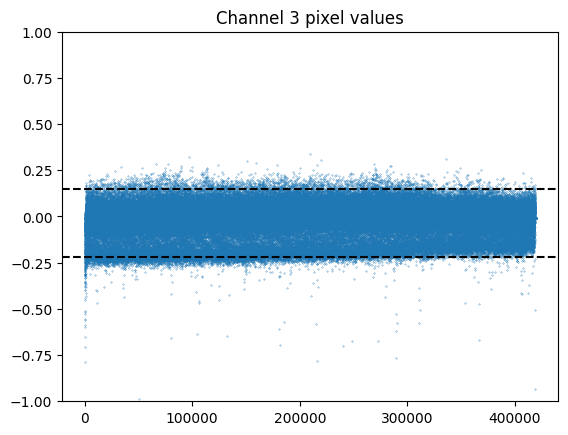

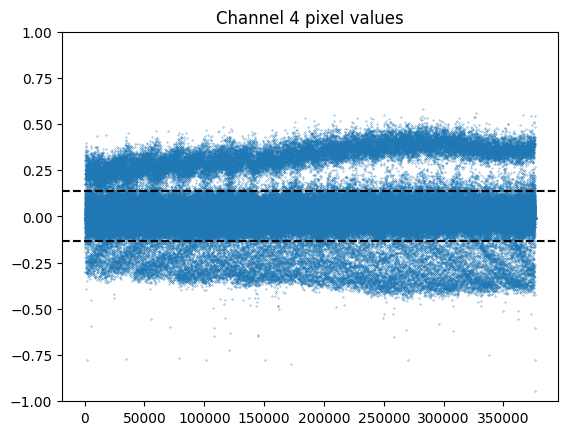

For Ch1, median value was -0.077
For Ch2, median value was -0.037
Short stack re-fill value = -0.006


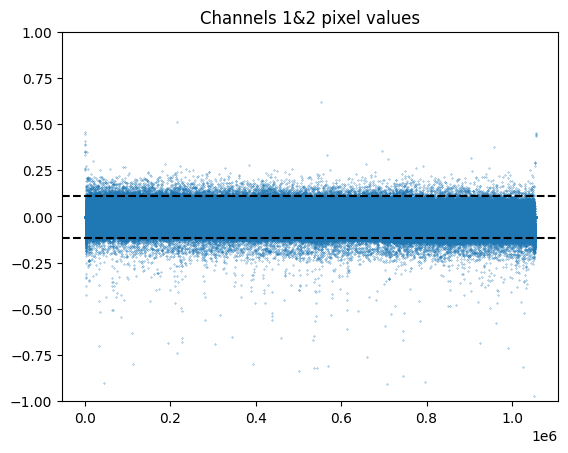

In [8]:
# from astropy.stats import sigma_clipped_stats


# Bad pixel mask refinement. Apologies that this code is not the most
# well-organized or prettiest....


# This cell uses the background exposures to identify and flag bad pixels
# processes each channel seperately. The x-axis in the produced plots is
# the pixel index, so not wavelength and has no real significance. And the
# y-axis is the value of each pixel in the flattened median image (for example 
# for Ch3 its the median pixel value of Ch3, subtracted from all Ch3 pixels, 
# ideally should be close to 0. For Ch4 it divides it into bins and subtracts 
# the medians of each bin from that bin).


if dobadpix:
    # This is a long command that sets... wait for it... dnubit = 1.
    dnubit = dqflags.interpret_bit_flags('DO_NOT_USE',mnemonic_map=datamodels.dqflags.pixel)
    
    # We will start with the LONG (channels 3 & 4) detector. Grab the background exposures.
    longrates = sorted(glob.glob(stage1+'jw*04101*mirifulong*rate.fits')) # remember that 04 is background and 02 is science
    nlong = len(longrates)
    
    # Assemble background exposures
    longstack = np.zeros([nlong,1024,1032])
    for i,exposure in enumerate(longrates):
        hdu = fits.open(exposure)
        longstack[i,:,:] = hdu['SCI'].data
        hdu.close()
    
    # Take the median of the exposures, then fix any pixels where the median is NaN
    longmedian = np.median(longstack,axis=0)
    fillvalue  = np.nanmedian(longmedian)
    print('Long stack fill value = {0:.3f}'.format(fillvalue))
    
    dqlong = (fits.open(longrates[0]))['DQ'].data
    bad = np.where((dqlong & dnubit) != 0)
    longmedian[bad] = fillvalue
    
    # Now write our median'd background to disk.
    hdu = fits.PrimaryHDU(longmedian)
    hdu.writeto(stage1+'background_median_mirifulong.fits',overwrite=True)
    
    
    # And the SHORT detector
    shortrates = sorted(glob.glob(stage1+'jw*04101*mirifushort*rate.fits'))
    nshort = len(shortrates)
    
    # Assemble background exposures
    shortstack = np.zeros([nshort,1024,1032])
    for i,exposure in enumerate(shortrates):
        hdu = fits.open(exposure)
        shortstack[i,:,:] = hdu['SCI'].data
        hdu.close()
    
    # Take the median of the exposures, then fix any pixels where the median is nan
    shortmedian = np.median(shortstack,axis=0)
    fillvalue  = np.nanmedian(shortmedian)
    print('Short stack fill value = {0:.3f}'.format(fillvalue))
    
    dqshort = (fits.open(shortrates[0]))['DQ'].data
    bad = np.where((dqshort & dnubit) != 0)
    shortmedian[bad] = fillvalue
    
    # Now write our median'd background to disk.
    hdu = fits.PrimaryHDU(shortmedian)
    hdu.writeto(stage1+'background_median_mirifushort.fits',overwrite=True)    
    

    # Now we have to identify the bad pixels based on their percentile value, but
    # since each channel has different pixel distributions (e.g. Ch4 has very low
    # throughput), we need to ID which pixels belong to which channel. This uses
    # the distortion files from the miricoord package.

    # Start again with the long exposures...
    # Note in this folder
    # MIRIFULONG vs MIRIFUSHORT = the two different detectors
    # 12SHORT / 12MEDIUM / 12LONG = channels 1 & 2 for band A=short B=medium C=long
    # 34SHORT / 34MEDIUM / 34LONG = channels 3 & 4 for band A=short B=medium C=long
    # so really having "34" and MIRIFULONG in the names is redundant, but whatever...
    
   
    
    miricoordpath = '/'.join(miricoord.__file__.split('/')[:-2])
    
    print(miricoordpath, type(miricoordpath))

    longslicemask  = miricoordpath + '/data/fits/flt3/MIRI_FM_MIRIFULONG_34LONG_DISTORTION_9B.05.07.fits'
    longslicemask  = (fits.open(longslicemask))['SLICE_NUMBER'].data[0,:,:]
    shortslicemask = miricoordpath + '/data/fits/flt3/MIRI_FM_MIRIFUSHORT_12LONG_DISTORTION_9B.05.07.fits'
    shortslicemask = (fits.open(shortslicemask))['SLICE_NUMBER'].data[0,:,:]
    ch1 = (shortslicemask >= 100) & (shortslicemask <= 130)
    ch2 = (shortslicemask >= 200) & (shortslicemask <= 230)
    ch3 = (longslicemask >= 300) & (longslicemask <= 330)
    ch4 = (longslicemask >= 400) & (longslicemask <= 430)
    
    # Get wavelength map for channel 4C. Since throughput falls so rapidly
    # towards the longer Ch4 wavelengths, we will calculate the background median
    # in wavelength chunks. Ch3 is way less affected by this so we just do it in
    # one fell swoop.
    wave4c = mrstools.waveimage('4C')
    
    # Subtract Ch3 average from Ch3 pixels
    ch3pix = np.where(ch3)
    ch3med = np.nanmedian(longmedian[ch3pix])
    longmedian[ch3pix] = longmedian[ch3pix] - ch3med
    print('For Ch3, median value was {0:.3f}'.format(ch3med))
    
    # The background in Ch4 varies strongly with wavelength so we have to subdivide it.
    # Ch4C spans from 23.942 - 28.785 um (unclear why this is different than the 
    #  jdox page on MRS, 23.22 - 28.10 um.....). 
    # Let's split it into ~0.33um spans, subtract a wave-dependent background.
    #mins = [ 1.0, 24.5, 25.0, 25.5, 26.0, 26.5, 27.0, 27.5, 28.0]
    mins = [1.0, 24.33, 24.67, 25.0, 25.33, 25.67, 26.0, 26.33, 26.67, 27.0, 27.33, 27.67, 28.0, 28.33]
    maxs = mins[1:] + [50.0]
    for i,lowave in enumerate(mins):
        hiwave = maxs[i]
        ch4pix = np.where(ch4 & (wave4c > lowave) & (wave4c <= hiwave))
        ch4med = np.nanmedian(longmedian[ch4pix])
        longmedian[ch4pix] = longmedian[ch4pix] - ch4med
        print('For wavelength range {0:.1f} - {1:.1f}um, found {2:.0f} pixels.'.format(lowave,hiwave,ch4pix[0].size))
        print('  Median value was {0:.3f}'.format(ch4med))
    
    # Update the median image with a new fill value, write to disk again...
    bad = np.where((dqlong & dnubit) != 0)
    fillvalue = np.nanmedian(longmedian)
    longmedian[bad] = fillvalue
    print('Long stack re-fill value = {0:.3f}'.format(fillvalue))
    hdu = fits.PrimaryHDU(longmedian)
    hdu.writeto(stage1+'background_median_refill_mirifulong.fits',overwrite=True)    
    
    # Now we start ID'ing pixels to mask, starting with channel 3
    longdqflags = np.zeros_like(dqlong)
    
    good_ch3 = np.where(ch3 & (longdqflags == 0) & (np.isfinite(longmedian)))
    f = plt.figure()
    ax = f.add_subplot(111)
    ax.plot(longmedian[good_ch3],'.',ms=0.5)
    ax.set_ylim(-1,1)
    ax.set_title('Channel 3 pixel values')
    
    # these values were identified 'by hand'; an alternative would be to
    # make some kind of percentile-based or sigma-clipped threshold value
    #-------------------------------------
    # pixel values outside of this range in the flatted bacground will be flagged
    # ch3lowcut, ch3hicut = -0.35, +0.15  # this is the hard coded original values
    ch3lowcut, ch3hicut = -0.22, +0.15
    #-------------------------------------

    ax.axhline(ch3lowcut,color='k',ls='--')
    ax.axhline(ch3hicut, color='k',ls='--')
    plt.show()
    plt.close(f)
    
    tomask = np.where(ch3 & (longmedian < ch3lowcut))
    longdqflags[tomask] = 1
    tomask = np.where(ch3 & (longmedian > ch3hicut))
    longdqflags[tomask] = 1
    

    # Now do the same thing for Ch4
    good_ch4 = np.where(ch4 & (longdqflags == 0) & (np.isfinite(longmedian)))
    f = plt.figure()
    ax = f.add_subplot(111)
    ax.plot(longmedian[good_ch4],'.',ms=0.5)
    ax.set_ylim(-1,1)
    ax.set_title('Channel 4 pixel values')
    
    # again ID'd cutoffs by hand from plot above
    #-------------------------------------
    ch4lowcut, ch4hicut = -0.13, +0.14
    #-------------------------------------

    ax.axhline(ch4lowcut,color='k',ls='--')
    ax.axhline(ch4hicut, color='k',ls='--')
    plt.show()
    plt.close(f)
    
    tomask = np.where(ch4 & (longmedian < ch4lowcut))
    longdqflags[tomask] = 1
    tomask = np.where(ch4 & (longmedian > ch4hicut))
    longdqflags[tomask] = 1
    
    longmedian_clean = longmedian.copy()
    bad = np.where(longdqflags == 1)
    longmedian_clean[bad] = fillvalue
    
    # Save the final 'clean' background to disk for long-wave detector
    hdu = fits.PrimaryHDU(longmedian_clean)
    hdu.writeto(stage1+'background_median_clean_mirifulong.fits',overwrite=True)
    
    # Now apply correction to our bg + sci files.
    longrates = sorted(glob.glob(stage1+'jw*mirifulong_rate.fits'))
    for i,rate in enumerate(longrates):
        hdu = fits.open(rate)
        outfile = rate.replace('rate','ratemod')
        dq = hdu['DQ'].data
        dq[bad] = np.bitwise_or(dq[bad], dnubit)
        hdu['DQ'].data = dq
        hdu.writeto(outfile,overwrite=True)
    


    # Now we repeat the above, but for Ch1 & 2 on the short-wave detector
    # Because the background in Chs 1 & 2 is much lower and more uniform
    # than 3&4, we don't need to process them separately and can just ID
    # one set of bad pixel threshold cuts.
    
    # Subtract Ch1 average from Ch1 pixels
    ch1pix = np.where(ch1)
    ch1med = np.nanmedian(shortmedian[ch1pix])
    shortmedian[ch1pix] = shortmedian[ch1pix] - ch1med
    print('For Ch1, median value was {0:.3f}'.format(ch1med))
    
    # Subtract Ch2 average from Ch2 pixels
    ch2pix = np.where(ch2)
    ch2med = np.nanmedian(shortmedian[ch2pix])
    shortmedian[ch2pix] = shortmedian[ch2pix] - ch2med
    print('For Ch2, median value was {0:.3f}'.format(ch2med))
    
    # Update the median image with a new fill value, write to disk again...
    bad = np.where((dqshort & dnubit) != 0)
    fillvalue = np.nanmedian(shortmedian)
    shortmedian[bad] = fillvalue
    print('Short stack re-fill value = {0:.3f}'.format(fillvalue))
    hdu = fits.PrimaryHDU(shortmedian)
    hdu.writeto(stage1+'background_median_refill_mirifushort.fits',overwrite=True)    
    
    # Now we start ID'ing pixels to mask
    shortdqflags = np.zeros_like(dqshort)
    
    good = np.where((shortdqflags == 0) & (np.isfinite(shortmedian)))
    
    f = plt.figure()
    ax = f.add_subplot(111)
    ax.plot(shortmedian[good],'.',ms=0.5)
    ax.set_ylim(-1,1)
    ax.set_title('Channels 1&2 pixel values')
    
    #--------------------------------------
    # lowcut, hicut = -0.08, +0.07 original values
    lowcut, hicut = -0.12, +0.11
    #--------------------------------------

    ax.axhline(lowcut,color='k',ls='--')
    ax.axhline(hicut, color='k',ls='--')
    plt.show()
    plt.close(f)
    
    tomask = np.where((shortmedian < lowcut))
    shortdqflags[tomask] = 1
    tomask = np.where((longmedian > hicut))
    shortdqflags[tomask] = 1

    shortmedian_clean = shortmedian.copy()
    bad = np.where(shortdqflags == 1)
    shortmedian_clean[bad] = fillvalue
    
    hdu = fits.PrimaryHDU(shortmedian_clean)
    hdu.writeto(stage1+'background_median_clean_mirifushort.fits',overwrite=True)
    
    # Now apply correction to our bg + sci files.
    shortrates = sorted(glob.glob(stage1+'jw*mirifushort_rate.fits'))
    for i,rate in enumerate(shortrates):
        hdu = fits.open(rate)
        outfile = rate.replace('rate','ratemod')
        dq = hdu['DQ'].data
        dq[bad] = np.bitwise_or(dq[bad], dnubit)
        hdu['DQ'].data = dq
        hdu.writeto(outfile,overwrite=True)


## Stage 2 Pipeline Processing

We will now run the rate files through the Spec2 pipeline - whether the bad pixel masks above were used or not. Like Stage 1, we will define a function where we set all the Spec2 pipeline options. *Unlike* Stage 1, we will perform a pixel-by-pixel 2D background subtraction in this step, which means we need to assemble an "association file" that tells the pipeline which exposures are science and which are background. 

The background subtraction step will create a median combination of the 4 background dithered exposures and subtract this from the science exposures. Because it can still be useful to run the background exposures through the Spec2 pipeline alone, we will do that as well, with a slightly different association file setup.

The final 2D combined background will be saved in `stage2/..._combinedbackground.fits` (the pipeline creates one copy of this for each on-source exposure but the contents are the same for each dither position).

Note this treatment of the background subtraction is different than the recommended best practices from shortly after launch but is now the default. Previously, the pipeline would by default create a 'master' 1D background spectrum from the background exposures, but this neglected all residual flatfield and 2D detector-level artifacts.

Both association file writing functions below specify some metadata for our program - observation 017 and program ID 1355 - but I (Justin) don't think this information is essential and doesn't need to be edited for other programs except for aesthetic reasons. You might also get some scare-text about how association files aren't supposed to be used with absolute file paths but this seems to be harmless. Why would anyone /only/ allow relative paths anyway??? Sounds like a recipe for problems to me.

In [9]:
def writel2asn_sci(scifiles, bgfiles, asnfile, prodname):
    """
    Write a .json association file that specifies a list of
    science and background exposures to be processed by Spec2.
    
    Arguments:
      * scifiles  :  List of on-source rate files to be processed.
      * bgfiles   :  List of background rate files to be processed.
      * asnfile   :  Output .json file path/name
      * prodname  :  Either 'Level2short' or 'Level2long', but this doesn't
                      really matter for much.
    
    Returns:
      * None
      
    Outputs:
      * Writes a .json association file to the location in `asnfile'
    """
    
    asn = afl.asn_from_list(scifiles, rule=DMSLevel2bBase, product_name=prodname)
    asn['asn_type'] = 'spec2'
    asn['asn_id']   = 'o017'
    asn['program']  = '01355'
    
    # Add background files to the association specified as exptype = background
    for bgfile in bgfiles:
        for i in range(len(scifiles)):
            asn['products'][i]['members'].append({'expname':bgfile, 'exptype': 'background'})
    
    # Write the association to a json file
    _, serialized = asn.dump()
    with open(asnfile, 'w') as outfile:
        outfile.write(serialized)


def writel2asn_bkg(bgfiles, asnfile, prodname):
    """
    Write a .json association file that specifies a list of
    background exposures **ONLY** to be processed by Spec2.
    This can be useful to inspect the _cal.fits images of the
    background exposures to look for remaining artifacts.
    
    Arguments:
      * bgfiles   :  List of background rate files to be processed.
      * asnfile   :  Output .json file path/name
      * prodname  :  Either 'Level2short' or 'Level2long', but this doesn't
                      really matter for much.

    Returns:
      * None
      
    Outputs:
      * Writes a .json association file to the location in `asnfile'
    """
    
    asn = afl.asn_from_list(bgfiles, rule=DMSLevel2bBase, product_name=prodname)
    asn['asn_type'] = 'spec2'
    asn['asn_id']   = 'o017'
    asn['program']  = '01355'
    
    # Write the association to a json file
    _, serialized = asn.dump()
    with open(asnfile, 'w') as outfile:
        outfile.write(serialized)

# Similar to Stage 1, this function is where we specify how the Spec2 pipeline
# should be run.
def runspec2(asnfile, outdir, nocubes=False):
    """
    Run the Spec2 file using the given association file. The association
    file must contain the information needed - sci and bg exposures - to
    run the pipeline.
    
    Arguments:
      * asnfile   :  Input .json file path/name that specifies the sci+bg exposures
      * outdir    :  Directory for the stage2 output files
      * nocubes   :  By default Spec2 builds a datacube from each exposure,
                      but this is time-consuming and imo not really needed.
                      If nocubes=True, will not build exposures cubes.
    
    Returns:
      * None
      
    Outputs:
      * Writes _cal.fits files for each exposure to `outdir'. Also saves
          median-combined background images to `outdir'. Additionally if
          nocubes=False, writes a 3D data cube built from each exposure
          to `outdir'.
    """
    
    
    # This initial setup is just to make sure that we get the latest parameter reference files
    # pulled in for our files.  This is a temporary workaround to get around an issue with
    # how this pipeline calling method works.
    crds_config = Spec2Pipeline.get_config_from_reference(asnfile)
    spec2 = Spec2Pipeline.from_config_section(crds_config)
    spec2.output_dir = outdir
    
    # Assign_wcs overrides
    #spec2.assign_wcs.override_distortion = 'myfile.asdf'
    #spec2.assign_wcs.override_regions = 'myfile.asdf'
    #spec2.assign_wcs.override_specwcs = 'myfile.asdf'
    #spec2.assign_wcs.override_wavelengthrange = 'myfile.asdf'

    # Flatfield overrides
    #spec2.flat.override_flat = 'myfile.fits'
        
    # Straylight overrides
    #spec2.straylight.override_mrsxartcorr = 'myfile.fits'
        
    # Fringe overrides
    #spec2.fringe.override_fringe = 'myfile.fits'
    
    # Photom overrides
    #spec2.photom.override_photom = 'myfile.fits'

    # Cubepar overrides
    #spec2.cube_build.override_cubepar = 'myfile.fits'
        
    # Extract1D overrides
    #spec2.extract1d.override_extract1d = 'myfile.asdf'
    #spec2.extract1d.override_apcorr = 'myfile.asdf'
        
    # Overrides for whether or not certain steps should be skipped
    # We do NOT want to skip background subtraction (although if this
    # is called on a bkg-only exposure it still gets processed correctly).
    #spec2.assign_wcs.skip = False
    spec2.bkg_subtract.skip = False
    #spec2.flat_field.skip = False
    #spec2.srctype.skip = False
    #spec2.straylight.skip = False
    #spec2.fringe.skip = False
    #spec2.photom.skip = False
    #spec2.cube_build.skip = False
    #spec2.extract_1d.skip = False
    
    # Pipeline now does 2D image background subtraction in stage 2.
    # Save the combined background image it makes (it will save 4 copies
    # of the same background, one for each sci dither exposure...).
    spec2.bkg_subtract.save_combined_background = True
    
    # We can skip cube-building for the individual science frames if desired.
    # Useful in cases where we want don't need the cubes of each science frame.
    if nocubes:
        spec2.cube_build.skip = True
        spec2.extract_1d.skip = True
    
    # By default the ResidualFringeStep is turned off even in the new dev version
    # Cal files don't seem to show much obvious fringing at least in the long detector
    # so I will leave this off.
    # spec2.residual_fringe.skip = False
    
    # Some cube building options
    #spec2.cube_build.weighting='drizzle'
    spec2.cube_build.coord_system='ifualign' # If aligning cubes with IFU axes instead of sky
      
    spec2.save_results = True
    spec2(asnfile)


In [ ]:
# Run through the destriped versions of the rate files.
if dobadpix:
    short_files_on  = sorted(glob.glob(here+'/'+stage1+'jw*02101*mirifushort*ratemod.fits'))
    short_files_sky = sorted(glob.glob(here+'/'+stage1+'jw*04101*mirifushort*ratemod.fits'))
    long_files_on   = sorted(glob.glob(here+'/'+stage1+'jw*02101*mirifulong*ratemod.fits'))
    long_files_sky  = sorted(glob.glob(here+'/'+stage1+'jw*04101*mirifulong*ratemod.fits'))
else:
    short_files_on  = sorted(glob.glob(here+'/'+stage1+'jw*02101*mirifushort*rate.fits'))
    short_files_sky = sorted(glob.glob(here+'/'+stage1+'jw*04101*mirifushort*rate.fits'))
    long_files_on   = sorted(glob.glob(here+'/'+stage1+'jw*02101*mirifulong*rate.fits'))
    long_files_sky  = sorted(glob.glob(here+'/'+stage1+'jw*04101*mirifulong*rate.fits'))


if dospec2:
    asnshort = os.path.join(stage2, 'level2_short_asn.json')
    asnlong  = os.path.join(stage2, 'level2_long_asn.json')
    bkgshort = os.path.join(stage2, 'level2_short_asn_bkg.json')
    bkglong  = os.path.join(stage2, 'level2_long_asn_bkg.json')
    writel2asn_sci(short_files_on, short_files_sky, asnshort, 'Level2short')
    writel2asn_sci(long_files_on,  long_files_sky,  asnlong,  'Level2long')
    writel2asn_bkg(short_files_sky, bkgshort, 'Level2short')
    writel2asn_bkg(long_files_sky,  bkglong,  'Level2long')
    runspec2(asnshort, outdir=stage2, nocubes=True)
    runspec2(asnlong,  outdir=stage2, nocubes=True)
    runspec2(bkgshort, outdir=stage2, nocubes=True)
    runspec2(bkglong,  outdir=stage2, nocubes=True)

## Stage 3 Pipeline Processing

Now we will assemble the calibrated 2D images into 3D data cubes. By default here I output one cube per channel, so we will have 4 cubes in total. Like before, we write an association file to tell the pipeline which exposures are science vs. background, and then a function that specifies how the Spec3 pipeline should run.

One can optionally do 1D master background subtraction here in Stage 3, if 2D pixel-by-pixel background subtraction was skipped above. The functions here are defined for that to be possible, but by default the pipeline will not "double-subtract" the background if 2D subtraction was already done.

In [11]:
# This piece of code checks CHANNELD and BAND metadata of the modified,
# (background subtracted) Stage 2 files.
def header_checker(folder_path, keyword_filters=None, name_contains=None, endswith="_uncal.fits"):
    """
    Go through JWST _uncal.fits files in a folder and check specified header keywords.
    
    Parameters:
    - folder_path (str): Path to the folder containing FITS files.
    - keyword_filters (list): List of FITS header keywords to extract (e.g., ['CHANNEL', 'BAND']).
    - name_contains (str): Optional substring the filename must contain (e.g., '04').
    
    Returns:
    - results (list of dict): Header values for matching files.
    """
    results = []

    for filename in os.listdir(folder_path):
        if filename.endswith(endswith) and (name_contains in filename if name_contains else True):
            filepath = os.path.join(folder_path, filename)
            try:
                with fits.open(filepath) as hdul:
                    header = hdul[0].header  # primary header
                    data = {'filename': filename}
                    for key in keyword_filters or []:
                        data[key] = header.get(key, 'N/A')
                    results.append(data)
            except Exception as e:
                print(f"Error reading {filename}: {e}")

    return results

folder = "/home/fatih/G165_main/G165_miri_bg_subtraction/data/JWST/science003/uncal"
keywords = ['CHANNEL', 'BAND']
bg_results = header_checker(folder, keyword_filters=keywords, name_contains="041")
sc_results = header_checker(folder, keyword_filters=keywords, name_contains="021")


print("Background Results:")
for r in bg_results:
    print(r)
# print(len(bg_results))

print("Science Results:")
for r in sc_results:
    print(r)

Background Results:
{'filename': 'jw03722003001_04101_00003_mirifulong_uncal.fits', 'CHANNEL': '34', 'BAND': 'MEDIUM'}
{'filename': 'jw03722003001_04101_00001_mirifushort_uncal.fits', 'CHANNEL': '12', 'BAND': 'MEDIUM'}
{'filename': 'jw03722003001_04101_00004_mirifulong_uncal.fits', 'CHANNEL': '34', 'BAND': 'MEDIUM'}
{'filename': 'jw03722003001_04101_00004_mirifushort_uncal.fits', 'CHANNEL': '12', 'BAND': 'MEDIUM'}
{'filename': 'jw03722003001_04101_00003_mirifushort_uncal.fits', 'CHANNEL': '12', 'BAND': 'MEDIUM'}
{'filename': 'jw03722003001_04101_00002_mirifulong_uncal.fits', 'CHANNEL': '34', 'BAND': 'MEDIUM'}
{'filename': 'jw03722003001_04101_00002_mirifushort_uncal.fits', 'CHANNEL': '12', 'BAND': 'MEDIUM'}
{'filename': 'jw03722003001_04101_00001_mirifulong_uncal.fits', 'CHANNEL': '34', 'BAND': 'MEDIUM'}
Science Results:
{'filename': 'jw03722003001_02101_00001_mirifulong_uncal.fits', 'CHANNEL': '34', 'BAND': 'LONG'}
{'filename': 'jw03722003001_02101_00003_mirifulong_uncal.fits', 'CHANN

In [12]:
def writel3asn(scifiles, bgfiles, asnfile, prodname='Level3'):
    """
    Write a .json association file that specifies a list of
    science and background exposures to be processed by Spec3.
    
    Arguments:
      * scifiles  :  List of on-source cal files to be processed.
      * bgfiles   :  List of background cal files to be processed.
      * asnfile   :  Output .json file path/name
      * prodname  :  AFAIK should just be 'Level3' always but prob
                      doesn't actually affect anything but metadata.
    
    Returns:
      * None
      
    Outputs:
      * Writes a .json association file to the location in `asnfile'    
    """
    
    # Define the basic association of science files
    asn = afl.asn_from_list(scifiles, rule=DMS_Level3_Base, product_name=prodname)
    asn['asn_type'] = 'spec3'
    asn['asn_id']   = 'o017'
    asn['program']  = '01355'
        
    # Add background files to the association
    for bgfile in bgfiles:
        asn['products'][0]['members'].append({'expname':bgfile, 'exptype': 'background'})
        
    # Write the association to a json file
    _, serialized = asn.dump()
    with open(asnfile, 'w') as outfile:
        outfile.write(serialized)


def runspec3(asnfile, outdir):
    """
    Run the Spec3 pipeline using the given association file. The association
    file must contain the information needed - sci and bg cal files - to
    run the pipeline.
    
    Arguments:
      * asnfile   :  Input .json file path/name that specifies the sci+bg exposures
      * outdir    :  Directory for the stage2 output files
    
    Returns:
      * None
      
    Outputs:
      * Writes _cal.fits files for each exposure to `outdir'. Also saves
          median-combined background images to `outdir'. Additionally if
          nocubes=False, writes a 3D data cube built from each exposure
          to `outdir'.
    """    
    
    
    
    # This initial setup is just to make sure that we get the latest parameter reference files
    # pulled in for our files.  This is a temporary workaround to get around an issue with
    # how this pipeline calling method works.
    crds_config = Spec3Pipeline.get_config_from_reference(asnfile)
    spec3 = Spec3Pipeline.from_config_section(crds_config)
    
    spec3.output_dir = stage3
    #spec3.save_results = True
    
    # Overrides for whether or not certain steps should be skipped
    #spec3.assign_mtwcs.skip = False
    #spec3.master_background.skip = True
    #spec3.outlier_detection.skip = True
    spec3.mrs_imatch.skip = False
    #spec3.cube_build.skip = False
    #spec3.extract_1d.skip = False
    
    # Grow out from outlying pixels (default was 1)
    spec3.outlier_detection.grow = 3
    
    # Cube building configuration options
    # The following was the set of parameters used to build the cubes
    #  used for Spilker et al. (2023). They were default at the time
    #  but the defaults have since been updated.
    # spec3.cube_build.channel = '3'    # Only build the Ch3 cube
    # spec3.cube_build.band    = 'long' # Only build from the long detector (seems redundant w/ Ch3)
    # spec3.cube_build.scale2  = 0.003  # Create cube with 0.003um wavelength channels (old default)
    # spec3.cube_build.output_file = 'bandcube' # Custom output name
    spec3.cube_build.output_type = 'band' # 'band', 'channel', or 'multi' type cube output
    # spec3.cube_build.weighting = 'drizzle' # 'emsm' or 'drizzle'
    
    # Instead of building a cube with N=up, this will build it aligned
    # with the actual along/across slice directions on the detector.
    # Needs to be this way in order for subsequent de-striping to work.
    spec3.cube_build.coord_system = 'ifualign' # 'ifualign', 'skyalign', or 'internal_cal'

    # Extract1D overrides
    #spec3.extract1d.override_extract1d = 'myfile.asdf'
    #spec3.extract1d.override_apcorr = 'myfile.asdf'

    spec3(asnfile)


In [ ]:
# Grab our lists of sci & background exposures.
# Note that since we did 2D bkg subtraction earlier we don't actually
# need these 1D backgrounds (they will be skipped by the Spec3 pipeline),
# but if you modified Spec2 above to *not* do 2D subtraction, this would
# be how you would use them for a 1D master background subtraction here.
scifiles = sorted(glob.glob(here+'/'+stage2+'jw*02101*cal.fits'))
bgfiles  = sorted(glob.glob(here+'/'+stage2+'jw*04101*x1d.fits'))

# Make an association file that includes all of the different exposures
asnfile=os.path.join(stage3, 'level3_asn.json')
if dospec3:
    writel3asn(scifiles, bgfiles, asnfile, 'Level3')
    runspec3(asnfile, outdir=stage3)

## Post-pipeline Cube Stripe Removal

Ordinarily the Spec3 pipeline above would be the end of the road for most "well-behaved" data processing; the `s3d.fits` files in `stage3/` would be science-ready. In fact if you are working with data that don't show strong cosmic ray shower artifacts, you will not need to run this next part.

Unfortunately for us, our data are strongly affected by the CR showers. You can see these as the large amorphous 'blobs' in the `_cal.fits` files produced in Stage 2 - most of those pixels are still unflagged even though the Stage 1 pipeline now has a preliminary way to identify and flag these lower-level jumps. Also unfortunately for us, the PAH emission is faint, the target galaxy SPT0418-47 has even fainter continuum, and the galaxy is extended over ~3" into an Einstein ring. We need every bit of sensitivity we can get, and the CR showers are the dominant remaining instrumental systematic.

Because the showers take up blobby regions on the detector that are a few dozen pixels wide, they typically are contained entirely within 1 or 2 of the MRS slices but hit every pixel within a slice. The diagram below (taken directly from the [MRS documentation](https://jwst-docs.stsci.edu/jwst-mid-infrared-instrument/miri-observing-modes/miri-medium-resolution-spectroscopy); Law et al. 2023 in prep.) can help illustrate why the CR showers get mapped into stripes when built with the `ifualign` option in the Spec3 `cube_build` step.

Let's look at the Channel 3 detector layout in yellow in the middle image. There are 16 vertical slices on the right half of the long-wavelength detector; these correspond to the y-dimension when mapped into the data cube. The cube's x-dimension corresponds to the along-slice direction - within each slice from right to left. Wavelength increases from top to bottom of the detector.

Now imagine you have a blobby CR shower a few dozen pixels in size sitting somewhere in that region. The shower is big enough to cover basically all pixels within 1 or 2 slices - so it will affect all of the cube's x pixels within the rows that correspond to that slice. But it's not big enough to cover all slices at once, so it only influences maybe 2 or 3 rows of the y-dimension in the cube. It also spans a few dozen pixels up/down on the detector, corresponding to the cube's wavelength dimension. The net effect is that CR showers produce horizontal stripes in the output cube that are a couple rows tall but coherent over tens of wavelength channels. The stripes aren't perfectly horizontal (even with `ifualign` in the cube building) because the slices are curved on the detector and the CR showers are blobby instead of rectangular.

Incidentally the shower removal techniques in the current (Feb. 2023) pipeline and our more aggressive jump flagging in Detector1 do greatly improve the data quality. Without them, horizontal stripes are visible even in individual channels of the data cube. With them, you have to average over >10 channels in order to beat down the noise and see the stripes come through.

In the following I lay out one way to address these stripes, demonstrated only on the Channel 3 cube that contains the PAH emission. The key is that (1) the position of the galaxy in the cube is well known from existing data (from ALMA), so we aren't blindly searching through the cube for signal, and (2) we have at least a few pixels on all sides of the source that can be used to estimate the stripe amplitude (i.e. the source doesn't run up against the edge of the cube). This method will not work if either of those is not true.

The basic steps are:
1. Use the known source position and shape to mask the Level 3 cube
2. Use the background tools in `photutils` to create a 'stripe template'
3. Subtract this stripe template from the cube

If you want to try this on different data, you will definitely need to change the definition of the cube mask to match your target. You will also probably want to play around with some of the choices I made in the following to see what impact they have on your results, but hopefully this is enough to get you started...

2025-09-29 03:36:08,860 - stpipe - WARNING - /home/fatih/G165_main/G165_miri_bg_subtraction/.venv/lib/python3.12/site-packages/astropy/wcs/wcs.py:805: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -99.435170 from OBSGEO-[XYZ].
Set OBSGEO-B to   -26.985830 from OBSGEO-[XYZ].
Set OBSGEO-H to 1626787635.706 from OBSGEO-[XYZ]'.
  warnings.warn(



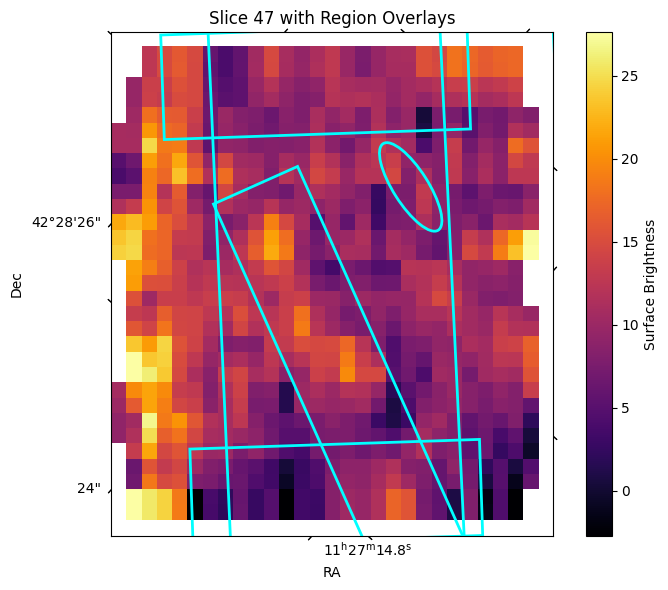

In [25]:
from astropy.io import fits
from astropy.wcs import WCS
from regions import Regions
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm

# --- File paths ---
cube_path = stage3 + 'Level3_ch2-long_s3d.fits'  # update if different
region_file = '/home/fatih/G165_main/G165_miri_bg_subtraction/data/carta_regions/ch2_cutting_sides4'  # path to your DS9 region file

# --- Load JWST cube ---
cube = fits.open(cube_path)
sci = cube['SCI'].data
dq = cube['DQ'].data
wcs2d = WCS(cube['SCI'].header, naxis=2)

# --- Load and convert DS9 elliptical regions to pixel regions ---
regions = Regions.read(region_file, format='ds9')
pixel_regions = [reg.to_pixel(wcs2d) for reg in regions]

# --- Create a 2D boolean mask (for one slice) from the elliptical regions ---
mask2d = np.zeros(sci.shape[1:], dtype=bool)
for preg in pixel_regions:
    thismask = preg.to_mask(mode='center').to_image(mask2d.shape)
    if thismask is not None:
        mask2d |= thismask.astype(bool)

# --- Expand to 3D source mask ---
# Takes the 2D mask and expands it to match the 3D shape of the science data
sourcemask = np.zeros(sci.shape, dtype=bool)
sourcemask[:] = mask2d

# --- Apply DQ mask and source mask ---
scimasked = np.ma.masked_array(sci, mask=(dq > 0))
scisourcemask = scimasked.copy()
scisourcemask.mask += sourcemask

# --- Display 47th slice with regions ---
slice_idx = 47
sci_slice = sci[slice_idx]
norm = simple_norm(sci_slice, 'linear', percent=99)

fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': wcs2d})
im = ax.imshow(sci_slice, origin='lower', cmap='inferno', norm=norm)

# Adds dotted gridlines for WCS coordinates
# ax.grid(color='white', ls='dotted')


# Plot each region correctly using as_artist
for sky_region in regions:
    pix_region = sky_region.to_pixel(wcs2d)
    artist = pix_region.as_artist(facecolor='none', edgecolor='cyan', lw=2)
    ax.add_patch(artist)

ax.set_title(f'Slice {slice_idx} with Region Overlays')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
plt.colorbar(im, ax=ax, label='Surface Brightness')
plt.tight_layout()
plt.show()


In [26]:
if dopost:
    from regions import Regions
    from astropy.wcs import WCS
    from astropy.coordinates import SkyCoord
    import astropy.units as u
    import numpy as np
    from astropy.visualization import ZScaleInterval, ImageNormalize
    from astropy.visualization import MinMaxInterval, LogStretch, SqrtStretch

    # Read in the pipe-produced Level 3 data cube for your desired channel
    cube = fits.open(stage3+'Level3_ch2-long_s3d.fits')
    sci  = cube['SCI'].data
    err  = cube['ERR'].data
    dq   = cube['DQ'].data
    scihead = cube['SCI'].header
    wcs = WCS(scihead)

    # Read your DS9 region file
    regions = Regions.read("/home/fatih/G165_main/G165_miri_bg_subtraction/data/carta_regions/ch2_cutting_sides4", format="ds9")

    # Create a mask from all the regions (applied to the full cube spatially)
    mask = np.zeros(sci.shape[1:], dtype=bool)  # 2D spatial mask


# Converts the regions in the DS9 file to pixel regions
# and builds a 2D mask of each region. 
for sky_region in regions:
    pix_region = sky_region.to_pixel(wcs.celestial)
    pix_mask = pix_region.to_mask(mode='center')
    
    if pix_mask is not None:
        mask_img = pix_mask.to_image(sci.shape[1:])
        if mask_img is not None:
            mask |= (mask_img > 0)


    wts  = err**-2   # w = 1/sigma^2, useful for weighted averages etc.
    scimasked = np.ma.masked_array(sci, mask = (dq>0)) # use DQ array to mask the science data

    # Apply the DS9 region mask across all slices of the cube (3D mask)
    sourcemask = np.zeros_like(sci, dtype=bool)
    for i in range(sci.shape[0]):
        sourcemask[i] = mask

    # Combine the DQ mask with custom region mask
    scisourcemask = scimasked.copy()
    scisourcemask.mask += sourcemask

    
    
    cubeavg     = np.zeros(scisourcemask.shape)
    cubeavg_wtd = np.zeros(scisourcemask.shape)
    cubebkg     = np.zeros(scisourcemask.shape)
    cubebkg_wtd = np.zeros(scisourcemask.shape)
    
    # ***
    chstep   = 25
    # ***
    halfstep = int((chstep-1)/2)
    bkg_estimator = MedianBackground() # From photutils
    
    for chstart in np.arange(halfstep, sci.shape[0]):
        cutout = np.ma.average(scisourcemask[chstart-halfstep:chstart+chstep+halfstep],axis=0)
        cutout2= np.ma.average(scisourcemask[chstart-halfstep:chstart+chstep+halfstep],axis=0,weights=wts[chstart-halfstep:chstart+chstep+halfstep])

        bkg = Background2D(cutout,  box_size=(1,int(np.ceil(cutout.shape[1]/2))), mask=(cutout.mask | sourcemask[0]), 
                filter_size=1, bkg_estimator=bkg_estimator, exclude_percentile=75.0)
        bkg2= Background2D(cutout2, box_size=(1,int(np.ceil(cutout.shape[1]/2))), mask=(cutout2.mask | sourcemask[0]), 
                filter_size=1, bkg_estimator=bkg_estimator, exclude_percentile=75.0)    

        cubeavg[chstart]     = cutout
        cubeavg_wtd[chstart] = cutout2
        cubebkg[chstart]     = bkg.background
        cubebkg_wtd[chstart] = bkg2.background
    
    # (rest of your code: padding, saving files, background subtraction - unchanged)
    # ...

    # Now writze the wavelength-smoothed cubes and backgrounds to disk.
    cubehdu = fits.PrimaryHDU(cubeavg,header=cube['SCI'].header)
    cubehdu.writeto(poststage3+'Level3_ch2-long_s3d_runningavg.fits',overwrite=True)
    cubehdu = fits.PrimaryHDU(cubeavg_wtd,header=cube['SCI'].header)
    cubehdu.writeto(poststage3+'Level3_ch2-long_s3d_runningweightedavg.fits',overwrite=True)
    bkghdu = fits.PrimaryHDU(cubebkg,header=cube['SCI'].header)
    bkghdu.writeto(poststage3+'Level3_ch2-long_s3d_background.fits',overwrite=True)
    bkghdu = fits.PrimaryHDU(cubebkg_wtd, header=cube['SCI'].header)
    bkghdu.writeto(poststage3+'Level3_ch2-long_s3d_weightedbackground.fits',overwrite=True)
    
    # Finally, also write out the background-subtracted cubes to disk
    bkgsub     = scimasked.data - cubebkg
    bkgsub_wtd = scimasked.data - cubebkg_wtd
    cubehdu = fits.PrimaryHDU(bkgsub,header=cube['SCI'].header)
    cubehdu.writeto(poststage3+'Level3_ch2-long_s3d_bkgsubtracted.fits',overwrite=True)
    cubehdu = fits.PrimaryHDU(bkgsub_wtd,header=cube['SCI'].header)
    cubehdu.writeto(poststage3+'Level3_ch2-long_s3d_bkgwtdsubtracted.fits',overwrite=True)



2025-09-29 03:36:13,280 - stpipe - WARNING - /home/fatih/G165_main/G165_miri_bg_subtraction/.venv/lib/python3.12/site-packages/astropy/wcs/wcs.py:805: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2024-05-14T19:26:37.741' from MJD-BEG.
Set DATE-AVG to '2024-05-14T20:33:43.264' from MJD-AVG.
Set DATE-END to '2024-05-14T21:40:48.787' from MJD-END'.
  warnings.warn(

2025-09-29 03:36:13,281 - stpipe - WARNING - /home/fatih/G165_main/G165_miri_bg_subtraction/.venv/lib/python3.12/site-packages/astropy/wcs/wcs.py:805: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -99.435170 from OBSGEO-[XYZ].
Set OBSGEO-B to   -26.985830 from OBSGEO-[XYZ].
Set OBSGEO-H to 1626787635.706 from OBSGEO-[XYZ]'.
  warnings.warn(



2025-09-29 03:36:54,383 - stpipe - WARNING - /home/fatih/G165_main/G165_miri_bg_subtraction/.venv/lib/python3.12/site-packages/astropy/wcs/wcs.py:805: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2024-05-14T19:26:37.741' from MJD-BEG.
Set DATE-AVG to '2024-05-14T20:33:43.264' from MJD-AVG.
Set DATE-END to '2024-05-14T21:40:48.787' from MJD-END'.
  warnings.warn(

2025-09-29 03:36:54,383 - stpipe - WARNING - /home/fatih/G165_main/G165_miri_bg_subtraction/.venv/lib/python3.12/site-packages/astropy/wcs/wcs.py:805: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -99.435170 from OBSGEO-[XYZ].
Set OBSGEO-B to   -26.985830 from OBSGEO-[XYZ].
Set OBSGEO-H to 1626787635.706 from OBSGEO-[XYZ]'.
  warnings.warn(



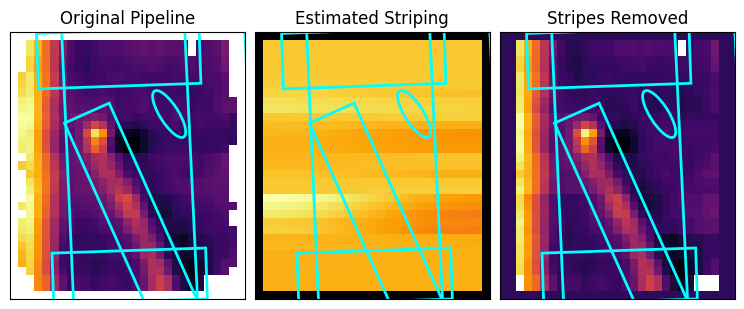

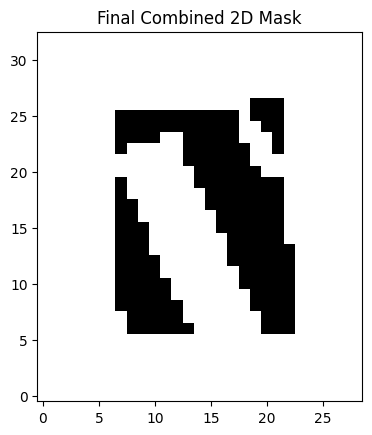

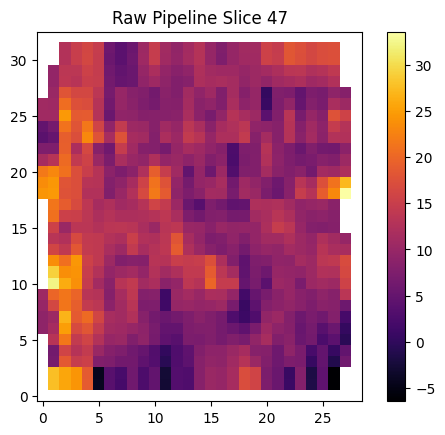

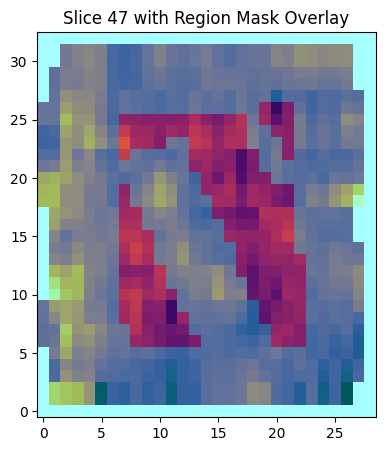

In [27]:
if True:
    from matplotlib.patches import Ellipse
    from regions import Regions
    from astropy.wcs import WCS


    # Channel range to average over
    #chstart, chstop = 500, 600
    chstart, chstop = 0, 690

    pipe = fits.open(stage3+'Level3_ch2-long_s3d.fits')['SCI'].data
    back = fits.open(poststage3+'Level3_ch2-long_s3d_background.fits')['SCI'].data
    bsub = fits.open(poststage3+'Level3_ch2-long_s3d_bkgsubtracted.fits')['SCI'].data

    back[:,:1,:]  = 0.
    back[:,-1:,:] = 0.
    back[:,:,:1]  = 0.
    back[:,:,-1:] = 0.
    bsub[:,:1,:]  = 0.
    bsub[:,-1:,:] = 0.
    bsub[:,:,:2]  = 0.
    bsub[:,:,-2:] = 0.


    # Average the data over the specified channel range to reduce noise and slice artifacts
    pipedata = np.ma.average(pipe[chstart:chstop], axis=0) 
    backdata = np.ma.average(back[chstart:chstop], axis=0)
    bsubdata = np.ma.average(bsub[chstart:chstop], axis=0)

    f,axarr = plt.subplots(figsize=(7.5,3),nrows=1,ncols=3)
    f.subplots_adjust(left=0.01,right=0.99,bottom=0.01,top=0.9,hspace=0,wspace=0)

    normC = ImageNormalize(backdata, interval=ZScaleInterval())
    normD = ImageNormalize(backdata, interval=ZScaleInterval(), stretch=LogStretch())

    axarr[0].imshow(pipedata, origin='lower', cmap='inferno')#, vmin=30, vmax=500)
    axarr[1].imshow(backdata, origin='lower', cmap='inferno')#, norm=normC)#, vmin=30, vmax=500)
    axarr[2].imshow(bsubdata, origin='lower', cmap='inferno')#, vmin=30, vmax=500)

    axarr[0].set_title('Original Pipeline',fontsize='large')
    axarr[1].set_title('Estimated Striping',fontsize='large')
    axarr[2].set_title('Stripes Removed',fontsize='large')

    # Read regions again for plotting
    regions = Regions.read("/home/fatih/G165_main/G165_miri_bg_subtraction/data/carta_regions/ch2_cutting_sides4", format="ds9")
    wcs = WCS(cube['SCI'].header).celestial

    for ax in axarr:
        # Plot circular mask as before
        # mask = Ellipse(xy=(xpeak+0.5,ypeak+0.5),width=2*rout,height=2*rout,angle=0.,ec='grey',fc='None')
        # ax.add_artist(mask)
        # Plot your DS9 ellipses converted to pixel coords
        for sky_region in regions:
            pix_region = sky_region.to_pixel(wcs)
            artist = pix_region.as_artist(facecolor='none', edgecolor='cyan', lw=2)
            ax.add_patch(artist)

        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()
    plt.close(f)

    plt.imshow(mask, origin='lower', cmap='gray')
    plt.title("Final Combined 2D Mask")
    plt.show()

    plt.imshow(pipe[47], origin='lower', cmap='inferno')#, vmin=20, vmax=80)
    plt.title("Raw Pipeline Slice 47")
    plt.colorbar()
    plt.show()

    slice_idx = 47
    fig, ax = plt.subplots(figsize=(6, 5))

    # Show the original image slice
    ax.imshow(sci[slice_idx], origin='lower', cmap='inferno')
    # Overlay the mask for that slice
    masked_overlay = np.ma.masked_where(~mask, mask)
    ax.imshow(masked_overlay, origin='lower', cmap='cool', alpha=0.35)
    ax.set_title(f"Slice {slice_idx} with Region Mask Overlay")
    plt.show()
        

In [20]:
# from regions import Regions
# from astropy.wcs import WCS
# 
# def make_mask_from_regions(regions_file, shape_2d, wcs_2d):
#     """
#     Create a 2D boolean mask from a DS9 region file and 2D WCS.
#     True = masked pixel
#     """
#     regions = Regions.read(regions_file, format='ds9')
#     mask_total = np.zeros(shape_2d, dtype=bool)
# 
#     for sky_region in regions:
#         pixel_region = sky_region.to_pixel(wcs_2d)
#         region_mask = pixel_region.to_mask(mode='center')
#         mask_data = region_mask.to_image(shape_2d)
#         mask_total |= (mask_data != 0)  # Combine with OR
# 
#     return mask_total
# 
# # This function can be used to create a mask from the regions file

In [ ]:
"""
if dopost:
    # Read in the pipe-produced Level 3 data cube for channel 3
    cube = fits.open(stage3+'Level3_ch3-long_s3d.fits')
    sci  = cube['SCI'].data
    err  = cube['ERR'].data
    dq   = cube['DQ'].data
    scihead = cube['SCI'].header

    # These will be useful
    wts  = err**-2   # w = 1/sigma^2, useful for weighted averages etc.
    scimasked = np.ma.masked_array(sci, mask = (dq>0)) # use DQ array to mask the science data
    
    # These define the pixel coordinates for the x and y center of the foreground lens,
    # plus a radius based on the Einstein ring size. I (JS) get consistent results whether
    # I get these using the cube's WCS information and ancillary ALMA data, or by collapsing
    # the whole cube over wavelength and visibly seeing the lens+ring.
    xpeak, ypeak, rout = 19.5, 18.0, 8.5
    
    # Now we create a boolean mask, circular in shape, using the above params.
    # This atrocious command masks a circle with radius=rout pix around the lens center
    circmask = (np.linalg.norm(np.argwhere(sci[0]) - np.array([ypeak,xpeak]), axis=1) < rout).reshape(sci[0].shape)
    
    # Now use that (2D) circular mask to mask the source in all (3D) cube channels.
    # Optionally I (JS) explored also masking some of the edge pixels which seem to
    # be junk, but they also have high ERR / low weight so in weighted stats they matter little
    sourcemask    = np.zeros(sci.shape, dtype=bool)
    sourcemask[:] = circmask
    # sourcemask[:, :, :2] = True # mask edges
    # sourcemask[:, :, 32] = True
    
    # Create a copy of the original (DQ masked) data but now include our
    # additional mask from above
    scisourcemask = scimasked.copy()
    scisourcemask.mask += sourcemask
    
    # We will calculate the stripe template using a running average over the
    # cube. There's an option to use either a straight average or a weighted average,
    # so we'll just make both.
    # These will be the smoothed cubes before stripe removal
    cubeavg     = np.zeros(scisourcemask.shape)
    cubeavg_wtd = np.zeros(scisourcemask.shape)
    # These will contain the estimated stripe templates
    cubebkg     = np.zeros(scisourcemask.shape)
    cubebkg_wtd = np.zeros(scisourcemask.shape)
    
    # Setup for our background/stripe estimation. Stripes are coherent over tens
    # of wavelength channels (remember cube has been "3d drizzled" so oversamples
    # the detectors spectral resolution). After some experimentation I settled on
    # a 25-channel running average.
    chstep   = 25
    halfstep = int((chstep-1)/2)
    bkg_estimator = MedianBackground() # From photutils
    
    for chstart in np.arange(halfstep, sci.shape[0]):
        cutout = np.ma.average(scimasked[chstart-halfstep:chstart+chstep+halfstep],axis=0)
        cutout2= np.ma.average(scimasked[chstart-halfstep:chstart+chstep+halfstep],axis=0,weights=wts[chstart-halfstep:chstart+chstep+halfstep])

        # Use photutils to estimate the 2D "background" (striping). The box_size
        # parameter sets the shape of the stripe estimation. Here using (1,shape[1]/2)
        # corresponds to fitting the "background" in a shape that is 1 row tall and
        # half the x-pixels of the cube, which allows enough flexibility to account
        # for the fact that the slices aren't perfectly x-aligned due to the slice
        # curvature on the detector. Also exclude_percentile is very high here because
        # in some rows most of the cube pixels are masked, where our circular source
        # mask is at its widest point.
        bkg = Background2D(cutout,  box_size=(1,int(np.ceil(cutout.shape[1]/2))), mask=(cutout.mask | sourcemask[0]), 
                filter_size=1, bkg_estimator=bkg_estimator, exclude_percentile=75.0)
        bkg2= Background2D(cutout2, box_size=(1,int(np.ceil(cutout.shape[1]/2))), mask=(cutout2.mask | sourcemask[0]), 
                filter_size=1, bkg_estimator=bkg_estimator, exclude_percentile=75.0)    

        # Overwrite our blank cubes with data
        cubeavg[chstart]     = cutout
        cubeavg_wtd[chstart] = cutout2
        cubebkg[chstart]     = bkg.background
        cubebkg_wtd[chstart] = bkg2.background
        
    # The above fails near the edge channels at the start/end of the cube,
    # pad those slices with the same background for convenience (and remember
    # to ignore edge channels in later analysis)
    cubeavg[0:halfstep]     = cubeavg[halfstep]
    cubeavg_wtd[0:halfstep] = cubeavg_wtd[halfstep]
    cubebkg[0:halfstep]     = cubebkg[halfstep]
    cubebkg_wtd[0:halfstep] = cubebkg[halfstep]
    cubeavg[-halfstep:]     = cubeavg[-halfstep]
    cubeavg_wtd[-halfstep:] = cubeavg_wtd[-halfstep]
    cubebkg[-halfstep:]     = cubebkg[-halfstep]
    cubebkg_wtd[-halfstep:] = cubebkg[-halfstep]
    
    # Now write the wavelength-smoothed cubes and backgrounds to disk.
    cubehdu = fits.PrimaryHDU(cubeavg,header=cube['SCI'].header)
    cubehdu.writeto(poststage3+'Level3_ch3-long_s3d_runningavg.fits',overwrite=True)
    cubehdu = fits.PrimaryHDU(cubeavg_wtd,header=cube['SCI'].header)
    cubehdu.writeto(poststage3+'Level3_ch3-long_s3d_runningweightedavg.fits',overwrite=True)
    bkghdu = fits.PrimaryHDU(cubebkg,header=cube['SCI'].header)
    bkghdu.writeto(poststage3+'Level3_ch3-long_s3d_background.fits',overwrite=True)
    bkghdu = fits.PrimaryHDU(cubebkg_wtd, header=cube['SCI'].header)
    bkghdu.writeto(poststage3+'Level3_ch3-long_s3d_weightedbackground.fits',overwrite=True)
    
    # Finally, also write out the background-subtracted cubes to disk
    bkgsub     = scimasked.data - cubebkg
    bkgsub_wtd = scimasked.data - cubebkg_wtd
    cubehdu = fits.PrimaryHDU(bkgsub,header=cube['SCI'].header)
    cubehdu.writeto(poststage3+'Level3_ch3-long_s3d_bkgsubtracted.fits',overwrite=True)
    cubehdu = fits.PrimaryHDU(bkgsub_wtd,header=cube['SCI'].header)
    cubehdu.writeto(poststage3+'Level3_ch3-long_s3d_bkgwtdsubtracted.fits',overwrite=True)
"""    

And that's it, we're finally done! As a quick check to see how well we did, let's try plotting up some random interval of the cube both with and without stripe removal.

In [ ]:
"""
# if dopost:
if True:
    xpeak, ypeak, rout = 19.5, 18.0, 8.5 # copied from above
    from matplotlib.patches import Ellipse

    # The starting and stopping channels of the cubes we should plot
    # You can play with these to see how the stripe properties vary
    # as a function of cube width etc.
    chstart, chstop = 500, 600

    pipe = fits.open(stage3+'Level3_ch3-long_s3d.fits')['SCI'].data
    back = fits.open(poststage3+'Level3_ch3-long_s3d_background.fits')['SCI'].data
    bsub = fits.open(poststage3+'Level3_ch3-long_s3d_bkgsubtracted.fits')['SCI'].data
    
    # Edge pixels are flagged in original cube, but not in mine (we ignored the
    # DQ arrays when writing back to disk), flag them here for consistency
    back[:,:1,:]  = 0.
    back[:,-1:,:] = 0.
    back[:,:,:1]  = 0.
    back[:,:,-1:] = 0.
    bsub[:,:1,:]  = 0.
    bsub[:,-1:,:] = 0.
    bsub[:,:,:2]  = 0.
    bsub[:,:,-2:] = 0.
    
    # Average the cube over the specified channel range
    pipedata = np.ma.average(pipe[chstart:chstop], axis=0)
    backdata = np.ma.average(back[chstart:chstop], axis=0)
    bsubdata = np.ma.average(bsub[chstart:chstop], axis=0)
    
    f,axarr = plt.subplots(figsize=(7.5,3),nrows=1,ncols=3)
    f.subplots_adjust(left=0.01,right=0.99,bottom=0.01,top=0.9,hspace=0,wspace=0)
    
    axarr[0].imshow(pipedata, origin='lower', cmap='jet')#, vmin=-3., vmax=3.0)
    axarr[1].imshow(backdata, origin='lower', cmap='jet')#, vmin=-3., vmax=3.0)
    axarr[2].imshow(bsubdata, origin='lower', cmap='jet')#, vmin=-3., vmax=3.0)
    
    axarr[0].set_title('Original Pipeline',fontsize='large')
    axarr[1].set_title('Estimated Striping',fontsize='large')
    axarr[2].set_title('Stripes Removed',fontsize='large')
    
    for ax in axarr:
        # note we actually shift the drawing of the masked regions bc matplotlib
        # defines pixels differently than numpy (it's a half-pixel thing as always)
        mask = Ellipse(xy=(xpeak+0.5,ypeak+0.5),width=2*rout,height=2*rout,angle=0.,ec='grey',fc='None')
        ax.add_artist(mask)
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()
    plt.close(f)
"""

Not too bad! We see that the very strong stripey artifacts are mostly gone now. There's still some mess around the edge pixels that weren't covered by all 4 dither positions, but the data are now in usable shape.

## Cube Analysis and Spectral Extraction

Here's a quick demonstration of how to work with these cubes to produce an estimate of the continuum and a PAH-only map (moment-0 for the radio astronomers). We'll assume just a constant continuum level, made from the wavelength ranges with no PAH emission (judged by JS' eyes from the spectrum).

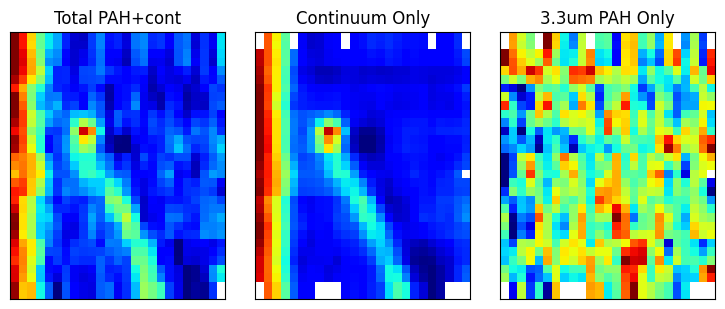

In [28]:
if doanalyze:
    # Read back in our cube in case above steps were skipped
    bkgsub = fits.open(poststage3+'Level3_ch2-long_s3d_bkgsubtracted.fits')['SCI'].data
    header = fits.open(poststage3+'Level3_ch2-long_s3d_bkgsubtracted.fits')['SCI'].header
    wave = np.arange(header['NAXIS3'])*header['CDELT3'] + header['CRVAL3'] # array of cube wavelengths
    
    
    # These channels correspond to the PAH feature, we don't expect any
    # other bright lines in the cube except this. PAH channel range
    # corresponds to approx. the FWHM of the line. All other channels
    # are counted as continuum, but we exclude 60 more channels on either
    # side of the above since the PAH image is the FWHM, not the FWZI.
    mom0start, mom0stop = 540, 650
    
    # which indices count as continuum?
    contix = np.ones(bkgsub.shape[0],dtype=bool)
    contix[mom0start-60:mom0stop+60] = False
    
    # Make estimates of the cont, PAH-only, and PAH wavelengths incl. continuum
    cont  = np.ma.average(bkgsub[contix], axis=0)
    total = np.ma.sum(bkgsub[mom0start:mom0stop], axis=0)
    mom0  = np.ma.sum(bkgsub[mom0start:mom0stop] - cont, axis=0)
    
    # Write these out to disk.
    momhdu = fits.PrimaryHDU(mom0.data,header=header)
    momhdu.header['CRVAL3'] = wave[int(np.mean([mom0start,mom0stop]))]
    momhdu.header['CDELT3'] = wave[mom0stop] - wave[mom0start]
    #momhdu.writeto(poststage3+'SPT0418-47_PAH3.3_mom0_contsubtract.fits',overwrite=True)

    momhdu = fits.PrimaryHDU(total.data,header=header)
    momhdu.header['CRVAL3'] = wave[int(np.mean([mom0start,mom0stop]))]
    momhdu.header['CDELT3'] = wave[mom0stop] - wave[mom0start]
    #momhdu.writeto(poststage3+'SPT0418-47_PAH3.3_mom0_nocontsubtract.fits',overwrite=True)

    conthdu = fits.PrimaryHDU(cont.data,header=header)
    conthdu.header['CRVAL3'] = np.mean(wave)
    #conthdu.writeto(poststage3+'SPT0418-47_ch3long_continuum.fits',overwrite=True)
    


# Just make a quick figure showing the 3 images we just made.
# In the above we ignored the DQ arrays, so the edge pixels that
# should be flagged will not be in the below. You can either blank
# them or just leave them, here I just choose not to plot them.
if doanalyze:
    f,axarr = plt.subplots(figsize=(7.5,3),nrows=1,ncols=3)
    f.subplots_adjust(left=0.01,right=0.99,bottom=0.01,top=0.9,hspace=0,wspace=0)
    
    axarr[0].imshow(total.data[1:-1,2:-2], origin='lower', cmap='jet', 
            vmin=np.nanpercentile(total.data[1:-1,2:-2],1.), vmax=np.nanpercentile(total.data[1:-1,2:-2],99.))
    axarr[1].imshow(cont.data[1:-1,2:-2],  origin='lower', cmap='jet', 
            vmin=np.nanpercentile(cont.data[1:-1,2:-2],1.), vmax=np.nanpercentile(cont.data[1:-1,2:-2],99.))
    axarr[2].imshow(mom0.data[1:-1,2:-2],  origin='lower', cmap='jet', 
            vmin=np.nanpercentile(mom0.data[1:-1,2:-2],1.), vmax=np.nanpercentile(mom0.data[1:-1,2:-2],99.))
    
    axarr[0].set_title('Total PAH+cont',fontsize='large')
    axarr[1].set_title('Continuum Only',fontsize='large')
    axarr[2].set_title('3.3um PAH Only',fontsize='large')
    
    for ax in axarr:
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()
    plt.close(f)

In the Total image, we are seeing continuum plus PAH emission, so the S/N is relatively high. In the cont-only image, you'll notice theres' a dot at the center of the ring - that's the foreground lens galaxy, which is a big bright elliptical galaxy at z=0.26 that still shows some faint emission out here at 17um. Because the PAH-only image has been continuum subtracted (which includes the lens), it's not present there.

And there you have it! Depending on how you ran the pipeline (plus any calibration file differences), the images above should be very similar to those published in Spilker et al. (2023). 

As a last exercise, let's pull out a spectrum of the lensed galaxy from the cube. We'll use a simple annular aperture. For kicks we will also demonstrate how to do this in sky coordinates (rather than pixel coordinates).

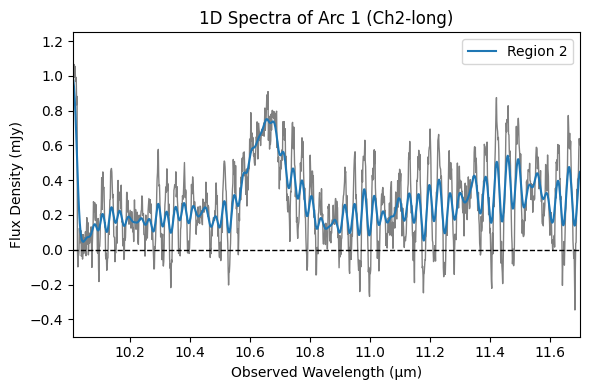

In [38]:
if doanalyze:
    import astropy.coordinates as coord
    import astropy.units as au
    from astropy.wcs import WCS
    from regions import Regions
    from photutils.aperture import aperture_photometry
    from scipy.ndimage import gaussian_filter1d
    import numpy as np
    import matplotlib.pyplot as plt
    from regions import Regions

    # Load bkg subtracted cube data and header
    bkgsub = fits.open(poststage3+'Level3_ch2-long_s3d_bkgsubtracted.fits')['SCI'].data
    dqarr  = fits.open(stage3+'Level3_ch2-long_s3d.fits')['DQ'].data
    header = fits.open(poststage3+'Level3_ch2-long_s3d_bkgsubtracted.fits')['SCI'].header
    wave = np.arange(header['NAXIS3']) * header['CDELT3'] + header['CRVAL3']
    pixareamjy = header['PIXAR_SR'] * 1e9

    # Convert 3D WCS → 2D WCS
    inwcs_cube = WCS(naxis=2)
    inwcs_cube.wcs.ctype = header['CTYPE1'], header['CTYPE2'] # 
    inwcs_cube.wcs.crval = header['CRVAL1'], header['CRVAL2'] # 
    inwcs_cube.wcs.crpix = header['CRPIX1'], header['CRPIX2'] # 
    inwcs_cube.wcs.cdelt = header['CDELT1'], header['CDELT2'] # 
    inwcs_cube.wcs.pc = [[header['PC1_1'], header['PC1_2']],
                         [header['PC2_1'], header['PC2_2']]]

    # Load your DS9 regions
    region_file = "/home/fatih/G165_main/G165_miri_bg_subtraction/data/carta_regions/ch2_cutting_sides4"
    regions = Regions.read(region_file, format="ds9")
    

    # Prepare plot
    fig, ax = plt.subplots(figsize=(6, 4))

    for i, sky_region in enumerate(regions): # loop over each region

        if i != 1:   # only keep Region 2
            continue

        pix_region = sky_region.to_pixel(inwcs_cube) # convert region to pixel coordinates
        srcspec = np.zeros(bkgsub.shape[0]) 

        for j in range(len(srcspec)): # loop over each channel j
            thisdq = dqarr[j] > 0

            # Performs aperture_photometry on the bkgsubtracted data
            # using the pixel region defined above as the aperture, 
            # and the DQ mask

            result = aperture_photometry(
                bkgsub[j],
                apertures=pix_region,
                method='subpixel',
                mask=thisdq,
                wcs=inwcs_cube
            )
            srcspec[j] = result['aperture_sum'][0] * pixareamjy 

        # Optional smoothing
        smoothspec = gaussian_filter1d(srcspec, sigma=6) # gaussian smoothing

        # Plot
        ax.plot(wave,srcspec,marker='None',ls='-',color='grey',lw=1)        
        ax.plot(wave,smoothspec,label=f"Region {i+1}", marker='None',ls='-',lw=1.5)
        #ax.plot(wave, smoothspec, label=f"Region {i+1}")
        

    ax.set_ylim(-0.5, 1.25)
    ax.set_xlim(min(wave), max(wave))
    ax.set_xlabel('Observed Wavelength (μm)')
    ax.set_ylabel('Flux Density (mJy)')
    ax.set_title("1D Spectra of Arc 1 (Ch2-long)")
    ax.axhline(0, color='k', ls='--', lw=1)
    ax.legend()
    plt.tight_layout()
    plt.show()


In [22]:
if doanalyze:
    import astropy.coordinates as coord
    import astropy.units as au
    from astropy.wcs import WCS
    from scipy.ndimage import gaussian_filter1d # smooth the spectrum if desired
    
    # These are from the ALMA imaging, or you can eyeball using the
    # images we made above
    pos = coord.SkyCoord('04h18m39.696s','-47d51m52.82s')
    rin, rout = 0.6*au.arcsec, 1.8*au.arcsec
    annulus = SkyCircularAnnulus(pos, r_in=rin, r_out=rout)
    
    # Read back in our cube in case above steps were skipped, plus the DQ array
    bkgsub = fits.open(poststage3+'Level3_ch3-long_s3d_bkgsubtracted.fits')['SCI'].data
    dqarr  = fits.open(stage3+'Level3_ch3-long_s3d.fits')['DQ'].data
    header = fits.open(poststage3+'Level3_ch3-long_s3d_bkgsubtracted.fits')['SCI'].header
    wave = np.arange(header['NAXIS3'])*header['CDELT3'] + header['CRVAL3'] # array of cube wavelengths
    pixareamjy = header['PIXAR_SR'] * 1e9 # From MJy/sr --> mJy/pix
    
    # photutils' aperture_photometry will fail if you try to
    # give it a 3D wcs from the cube because it only works on 2D
    # images. Let's recreate a 2D version of the cube's spatial wcs.
    inwcs_cube = WCS(naxis=2)
    inwcs_cube.wcs.ctype = header['CTYPE1'], header['CTYPE2']
    inwcs_cube.wcs.crval = header['CRVAL1'], header['CRVAL2']
    inwcs_cube.wcs.crpix = header['CRPIX1'], header['CRPIX2']
    inwcs_cube.wcs.cdelt = header['CDELT1'], header['CDELT2']
    inwcs_cube.wcs.pc  = [[header['PC1_1'],  header['PC1_2']],
                          [header['PC2_1'],  header['PC2_2']]]
    
    # Loop over channels and get source flux (in mJy) at each channel
    srcspec = np.zeros(bkgsub.shape[0])
    for i in range(srcspec.size):
        thisdq = (dqarr[i,:,:] > 0) # Convert the DQ channel into a True/False array
        photann = aperture_photometry(bkgsub[i,:,:], apertures=annulus, method='subpixel', mask=thisdq, wcs=inwcs_cube)
        srcspec[i] = photann['aperture_sum'][0] * pixareamjy
    
    # Smooth the spectrum if desired
    smoothspec = gaussian_filter1d(srcspec, sigma=10)
    
    f,ax = plt.subplots(figsize=(4,4),nrows=1,ncols=1)
    
    ax.plot(wave,srcspec,marker='None',ls='-',color='grey',lw=1)
    ax.plot(wave,smoothspec,marker='None',ls='-',color='navy',lw=2)
    
    # Draw lines for 0 flux and a very rough continuum
    ax.axhline(0,color='k',ls='-',zorder=0)
    ax.axhline(np.nanmean(srcspec[:400]),ls=':',color='k',lw=1,zorder=1)
    
    ax.set_xlabel('Observed Wavelength (um)')
    ax.set_ylabel('Flux Density (mJy)')
    
    plt.show()
    plt.close(f)

ValueError: r_out must be greater than r_in

## Lessons Learned and Future Improvements

That's all I've got to show you right now. I thought it would be nice to conclude with some lessons we've learned that might help others design better observing programs in the future.

### Lessons Learned
- Our CR shower de-striping technique relies on having enough background pixels around the source position to estimate the stripe amplitudes. Our data used "primary channel" = "ALL", which roughly centers the source in all 4 MRS channels. In this particular case, if we were willing to sacrifice the other channels to some extent, SPT0418-47 could have been centered better in Channel 3, the one of primary interest.
- Dedicated background exposures. Our data used 4 background exposures, reaching the same integration time as the on-source data. I (JS) have tried to reduce these data ignoring the backgrounds completely and it was a total disaster. It seems some dedicated backgrounds really are needed - but whether it's okay to get away with less background exposure time is still TBD.

### Future Improvements
- CR Shower treatment. I really hope one day the pipeline is mature enough to identify and flag the CR showers, which would make a whole lot of the pain above unnecessary anymore.
- Incorporate the simultaneous MIRI imaging. I (JS) have seen notebooks floating around that use the imager data to confirm/improve the astrometry for the MRS data. That wasn't necessary here because (at least at 0.6" resolution) there was no evidence for an astrometric offset between MRS and ALMA.
- Ongoing calibration updates. At this early stage, many of the reference files are still in flux and will presumably improve with time. The bad pixel mask, for example, would save a lot of effort.
